In [136]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [138]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from time import  time

from torchvision.utils import make_grid
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import random

from bhsgan import DiscriminatorBhsMnist, GeneratorBhsMnist
from ipmbhsgan import DiscriminatorIpmMnist, GeneratorIpmMnist
from trainer import *
from utils import *
#get_device, get_noise, init_weights, plot_tensor_images, plot_losses, Positive, RevKlActivation
from wgan import DiscriminatorWassersteinMnist, GeneratorWassersteinMnist
from torch.utils.tensorboard import SummaryWriter

In [4]:
# create dataloader
batch_size = 128
device = get_device()

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=train_transform),
    batch_size=batch_size,
    shuffle=True)

Time is 0.0220186710357666 sec
Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


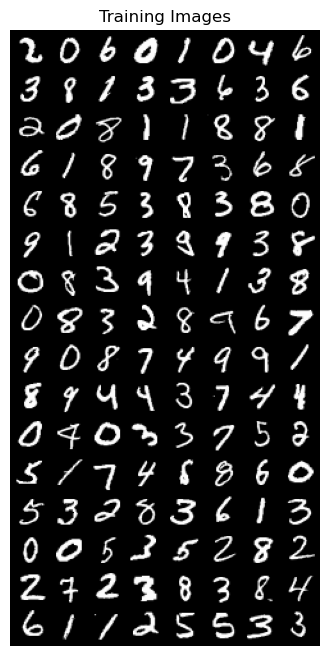

In [5]:
start = time()
dataiter = iter(dataloader)
images,labels = dataiter._next_data()
print ('Time is {} sec'.format(time()-start))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(dataloader))

In [6]:
latent_dim = 100
latent_dim_bhs = 28*28
batch_size_bhs = 128
test_noise = get_noise(25, latent_dim, device)
test_noise_bhs = get_noise(25, latent_dim_bhs, device)

## First I train a Wasserstein GAN

In [5]:
training_params = TrainingParams(lr_dis=0.0002,
                                 lr_gen=0.0002,
                                 num_epochs=1,
                                 num_dis_updates=5,
                                 num_gen_updates=1,
                                 beta_1=0.5,
                                 batch_size=batch_size)

In [88]:
generator_wasserstein = GeneratorWassersteinMnist(latent_dim).apply(init_weights)
discriminator_wasserstein = DiscriminatorWassersteinMnist(28*28).apply(init_weights)
trainer_wgan = Trainer(training_params, generator_wasserstein, discriminator_wasserstein, device=device)

In [89]:
# training loop
trained_wgan = trainer_wgan.train_gan(dataloader, get_dis_loss_wasserstein, get_gen_loss_wasserstein, True, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 16.399503	Loss_C : -3.314907	Loss_G : -3.833015	
Total_Time : 16.399503
Loss_C : -3.314907
Loss_G : -3.833015
Loss_C_Mean : -3.597823
Loss_G_Mean : -1.360363

----------------------------------------------



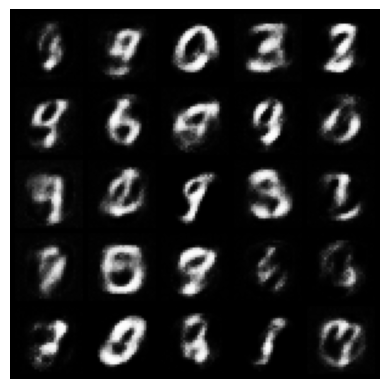

In [90]:
# show generated images
generated_images_wasserstein = trained_wgan.generator(test_noise)
plot_tensor_images(generated_images_wasserstein, num_images=25)

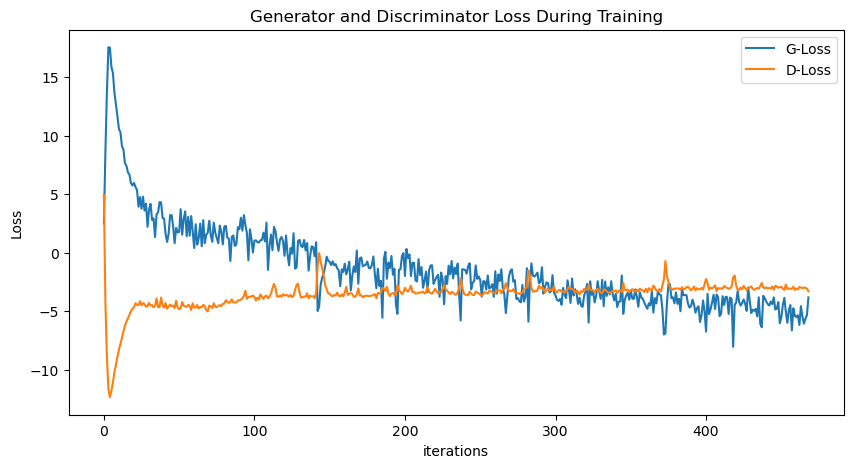

In [96]:
# plot losses
plot_losses(trained_wgan.generator_losses, trained_wgan.discriminator_losses)

## BHS Gan
$f^*(x) = 2(-1+\sqrt{1+x})\exp(\sqrt{1+x})$

In [35]:
torch.manual_seed(1)
random.seed(1)

training_params_bhs = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=5, num_dis_updates=4, num_gen_updates=3, beta_1=0.5, batch_size=batch_size_bhs)
generator_bhs = GeneratorBhsMnist(Positive, latent_dim_bhs)
discriminator_bhs = DiscriminatorBhsMnist(Positive, 28*28)
trainer_bhs = Trainer(training_params_bhs, generator_bhs, discriminator_bhs, device=device)

In [36]:
trained_bhsgan = trainer_bhs.train_gan(dataloader, get_dis_loss_bhs, get_gen_loss_bhs, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/5 Total Steps:469
Total_Time : 14.739853
Loss_C : 0.031877
Loss_G : -0.093411
Loss_C_Mean : 0.029058
Loss_G_Mean : -0.174590

----------------------------------------------

Epoch 2 start training...
Epoch: 2/5 Total Steps:938
Total_Time : 14.714191
Loss_C : 0.010477
Loss_G : -0.048141
Loss_C_Mean : 0.015368
Loss_G_Mean : -0.069947

----------------------------------------------

Epoch 3 start training...
Epoch: 3/5 Total Steps:1407
Total_Time : 14.404320
Loss_C : 0.021638
Loss_G : -0.080530
Loss_C_Mean : 0.007411
Loss_G_Mean : -0.062637

----------------------------------------------

Epoch 4 start training...
Epoch: 4/5 Total Steps:1876
Total_Time : 14.506510
Loss_C : -0.001772
Loss_G : -0.049428
Loss_C_Mean : 0.008065
Loss_G_Mean : -0.059496

----------------------------------------------

Epoch 5 start training...
Epoch: 5/5 Total Steps:2345
Total_Time : 14.592572
Loss_C : -0.002339
Loss_G : -0.034992
Loss_C_Mean : 0.010363
Loss_G_Mean : -0.055470

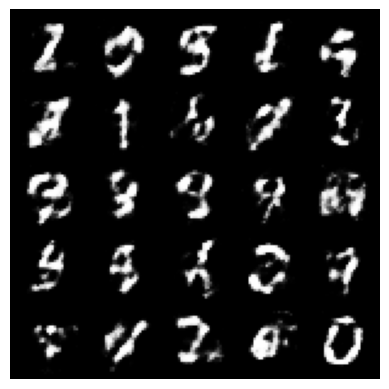

In [37]:
# show generated images
generated_images_bhs = trained_bhsgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_bhs, num_images=25)

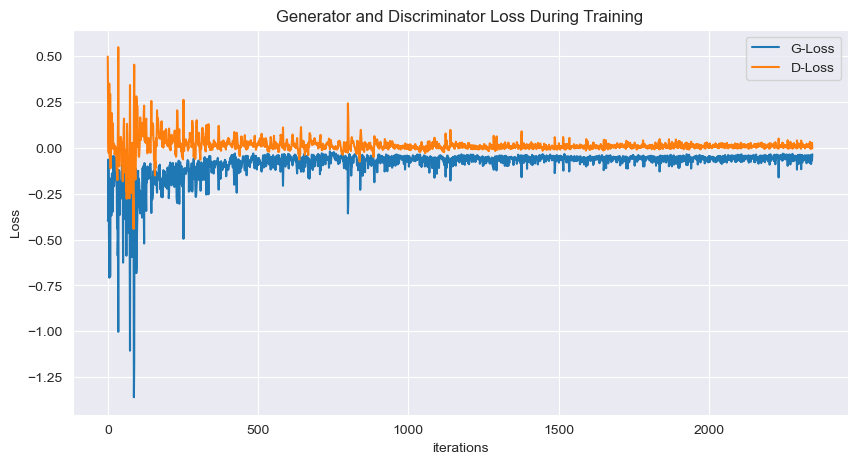

In [38]:
# plot losses
plot_losses(trained_bhsgan.generator_losses, trained_bhsgan.discriminator_losses)

## KL GAN
$f^*(x) = \exp(x-1)$


In [70]:
torch.manual_seed(1)
random.seed(1)

training_params_KL = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=5, num_dis_updates=4, num_gen_updates=3, beta_1=0.5, batch_size=batch_size_bhs)
generator_KL = GeneratorBhsMnist(latent_dim_bhs)
discriminator_KL = DiscriminatorBhsMnist(nn.Identity, 28*28)
trainer_kl = Trainer(training_params_KL, generator_KL, discriminator_KL, device=device)

In [71]:
trained_klgan = trainer_kl.train_gan(dataloader, get_dis_loss_kl, get_gen_loss_kl, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/5 Total Steps:469
Total_Time : 13.395441
Loss_C : -1.918380
Loss_G : -0.651850
Loss_C_Mean : -0.581362
Loss_G_Mean : -0.687118

----------------------------------------------

Epoch 2 start training...
Epoch: 2/5 Total Steps:938
Total_Time : 13.411397
Loss_C : -0.207213
Loss_G : -0.766150
Loss_C_Mean : -0.335729
Loss_G_Mean : -0.855187

----------------------------------------------

Epoch 3 start training...
Epoch: 3/5 Total Steps:1407
Total_Time : 13.432667
Loss_C : -0.022769
Loss_G : -1.003130
Loss_C_Mean : -0.251458
Loss_G_Mean : -1.008534

----------------------------------------------

Epoch 4 start training...
Epoch: 4/5 Total Steps:1876
Total_Time : 13.396674
Loss_C : -0.256568
Loss_G : -1.079361
Loss_C_Mean : -0.334568
Loss_G_Mean : -1.006448

----------------------------------------------

Epoch 5 start training...
Epoch: 5/5 Total Steps:2345
Total_Time : 13.222306
Loss_C : -0.329945
Loss_G : -0.861794
Loss_C_Mean : -0.337639
Loss_G_Mean : -

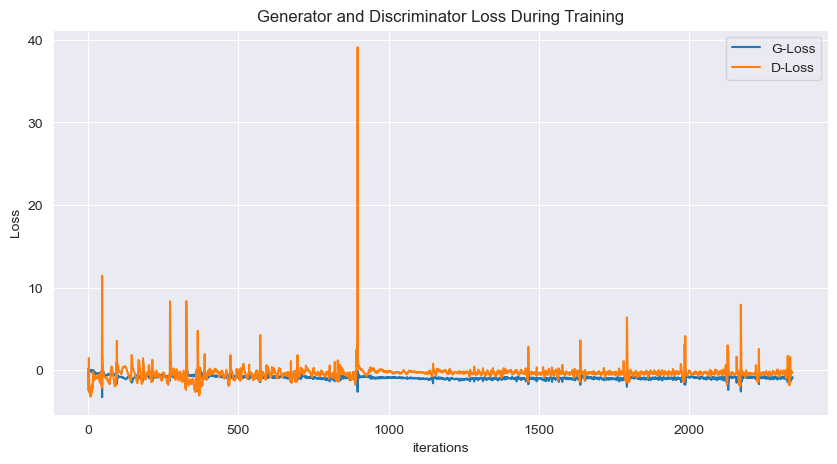

In [72]:
plot_losses(trained_klgan.generator_losses, trained_klgan.discriminator_losses)

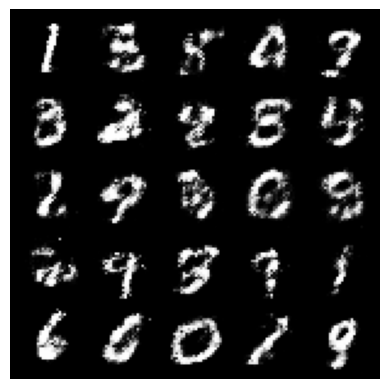

In [73]:
generated_images_kl = trained_klgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_kl, num_images=25)

## Rev KL GAN
$f^*(x) = -1 - \log(x)$


In [128]:
torch.manual_seed(2)
random.seed(2)

training_params_RKL = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=5, num_dis_updates=4, num_gen_updates=3,
                                    beta_1=0.5, batch_size=batch_size_bhs)
generator_RKL = GeneratorBhsMnist(latent_dim_bhs)
discriminator_RKL = DiscriminatorBhsMnist(RevKlActivation, 28 * 28)
trainer_rkl = Trainer(training_params_RKL, generator_RKL, discriminator_RKL, device=device)


In [129]:
trained_rklgan = trainer_rkl.train_gan(dataloader, get_dis_loss_rkl, get_gen_loss_rkl, False, flatten_dim=28 * 28)

Epoch 1 start training...
Epoch: 1/5 Total Steps:469
Total_Time : 14.912755
Loss_C : 0.318102
Loss_G : -0.303061
Loss_C_Mean : 0.363095
Loss_G_Mean : -0.342846

----------------------------------------------

Epoch 2 start training...
Epoch: 2/5 Total Steps:938
Total_Time : 14.992366
Loss_C : 0.356612
Loss_G : -0.188829
Loss_C_Mean : 0.348802
Loss_G_Mean : -0.282772

----------------------------------------------

Epoch 3 start training...
Epoch: 3/5 Total Steps:1407
Total_Time : 14.877235
Loss_C : 0.370916
Loss_G : -0.258292
Loss_C_Mean : 0.354976
Loss_G_Mean : -0.256265

----------------------------------------------

Epoch 4 start training...
Epoch: 4/5 Total Steps:1876
Total_Time : 14.584719
Loss_C : 0.379769
Loss_G : -0.293224
Loss_C_Mean : 0.364120
Loss_G_Mean : -0.289421

----------------------------------------------

Epoch 5 start training...
Epoch: 5/5 Total Steps:2345
Total_Time : 14.514348
Loss_C : 0.376314
Loss_G : -0.338576
Loss_C_Mean : 0.370419
Loss_G_Mean : -0.324227



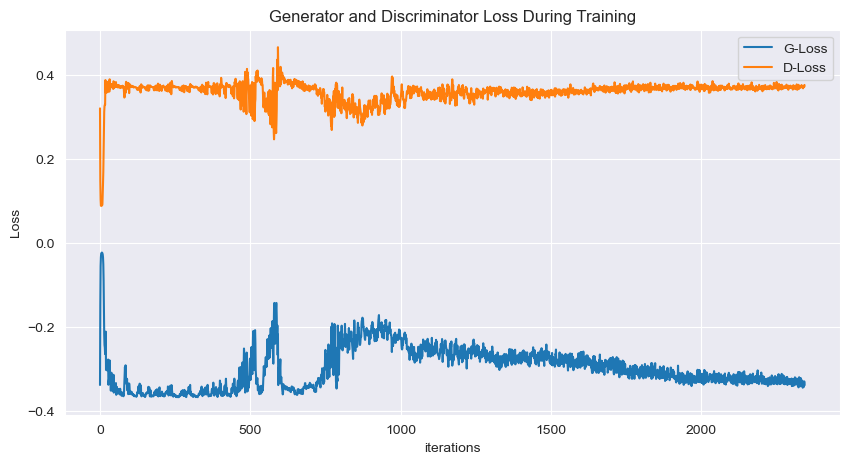

In [130]:
plot_losses(trained_rklgan.generator_losses, trained_rklgan.discriminator_losses)

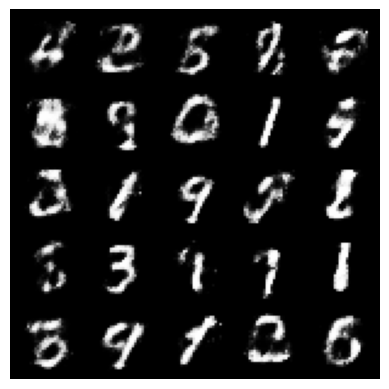

In [131]:
generated_images_rkl = trained_rklgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_rkl, num_images=25)

## Pearson GAN
$f^*(x) = \frac{1}{4} x^2 + x$

In [132]:
torch.manual_seed(2)
random.seed(2)

training_params_pgan = TrainingParams(lr_dis=0.0002, lr_gen=0.001, num_epochs=1, num_dis_updates=1, num_gen_updates=1,
                                     beta_1=0.5, batch_size=batch_size_bhs)
generator_pgan = GeneratorBhsMnist(latent_dim_bhs)
discriminator_pgan = DiscriminatorBhsMnist(nn.Identity,28 * 28)
trainer_kl = Trainer(training_params_pgan, generator_pgan, discriminator_pgan, device=device)


In [133]:
trained_pgan = trainer_kl.train_gan(dataloader, get_dis_loss_p, get_gen_loss_p, False, flatten_dim=28 * 28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469
Total_Time : 8.771261
Loss_C : nan
Loss_G : nan
Loss_C_Mean : nan
Loss_G_Mean : nan

----------------------------------------------



C:\Users\Rick\.conda\envs\Torch\lib\site-packages\matplotlib\cm.py:440: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


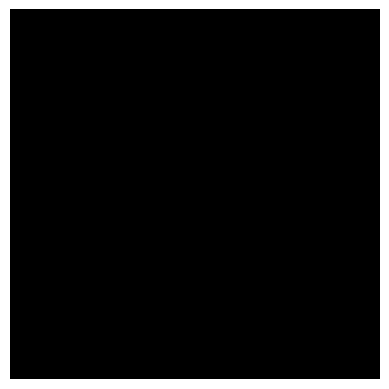

In [134]:
generated_images_pgan = trained_pgan.generator(test_noise_bhs)
plot_tensor_images(generated_images_pgan, num_images=25)


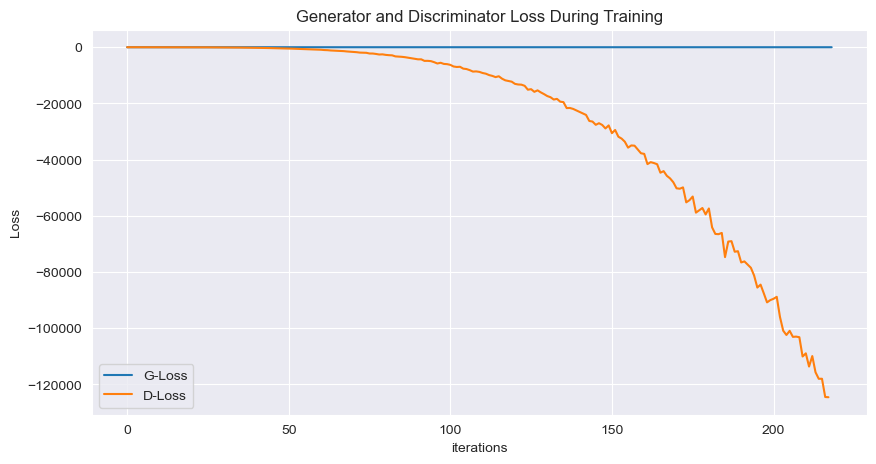

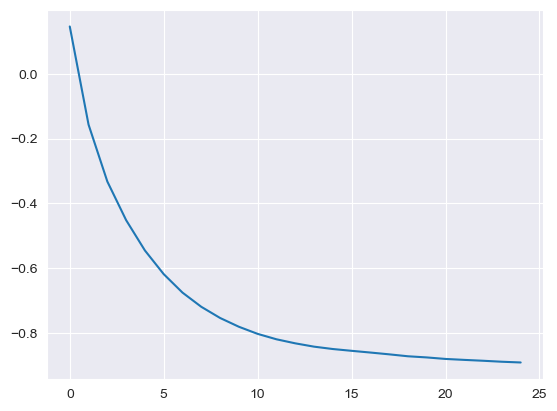

In [135]:
plot_losses(trained_pgan.generator_losses, trained_pgan.discriminator_losses)
plt.plot(trained_pgan.generator_losses[0:25])

## GAN GAN
$f^*(x) = -\log(1-\exp(x))$

In [160]:
torch.manual_seed(2)
random.seed(2)

training_params_GAN = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=5, num_dis_updates=4, num_gen_updates=3,
                                    beta_1=0.5, batch_size=batch_size_bhs)
generator_GAN = GeneratorBhsMnist(latent_dim_bhs)
discriminator_GAN = DiscriminatorBhsMnist(RevKlActivation, 28 * 28)
trainer_gan = Trainer(training_params_GAN, generator_GAN, discriminator_GAN, device=device)

In [161]:
trained_gan = trainer_gan.train_gan(dataloader, get_dis_loss_gan, get_gen_loss_gan, False, flatten_dim=28 * 28)

Epoch 1 start training...
Epoch: 1/5 Total Steps:469
Total_Time : 15.233821
Loss_C : 0.109281
Loss_G : -0.430516
Loss_C_Mean : 0.055647
Loss_G_Mean : -0.140938

----------------------------------------------

Epoch 2 start training...
Epoch: 2/5 Total Steps:938
Total_Time : 14.938079
Loss_C : 0.058275
Loss_G : -0.032681
Loss_C_Mean : 0.097774
Loss_G_Mean : -0.175979

----------------------------------------------

Epoch 3 start training...
Epoch: 3/5 Total Steps:1407
Total_Time : 14.939072
Loss_C : 0.032489
Loss_G : -0.016642
Loss_C_Mean : 0.056110
Loss_G_Mean : -0.059399

----------------------------------------------

Epoch 4 start training...
Epoch: 4/5 Total Steps:1876
Total_Time : 14.972388
Loss_C : 0.074272
Loss_G : -0.039975
Loss_C_Mean : 0.033613
Loss_G_Mean : -0.014923

----------------------------------------------

Epoch 5 start training...
Epoch: 5/5 Total Steps:2345
Total_Time : 15.036100
Loss_C : 0.019211
Loss_G : -0.000142
Loss_C_Mean : 0.048458
Loss_G_Mean : -0.052797



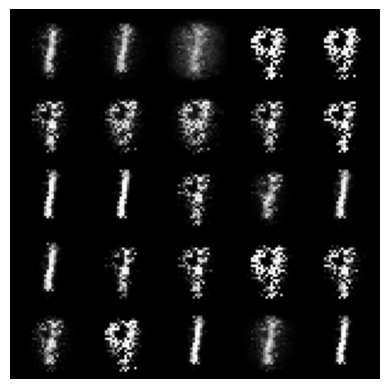

In [162]:
generated_images_gan = trained_gan.generator(test_noise_bhs)
plot_tensor_images(generated_images_gan, num_images=25)

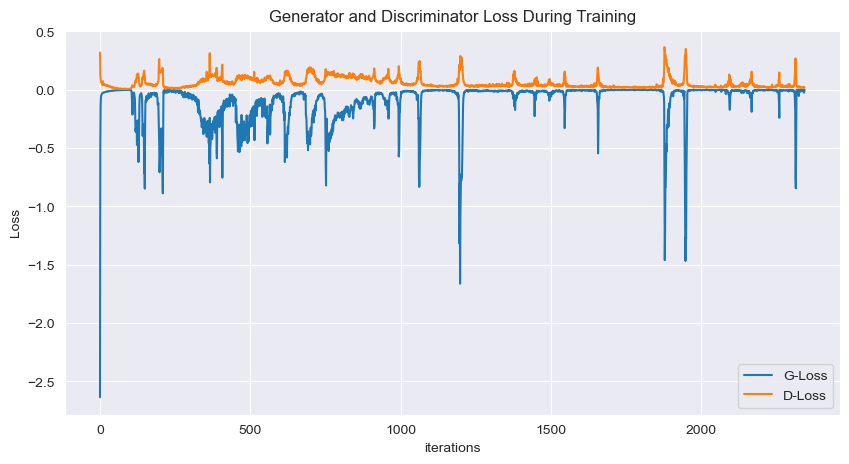

In [163]:
plot_losses(trained_gan.generator_losses, trained_gan.discriminator_losses)


## IPM BHS GAN

In [17]:
training_params_ipm = TrainingParams(lr_dis=0.0002, lr_gen=0.0002, num_epochs=1, num_dis_updates=5, num_gen_updates=1, beta_1=0.5, batch_size=batch_size)
generator_ipm = GeneratorIpmMnist(latent_dim).apply(init_weights)
discriminator_ipm = DiscriminatorIpmMnist(28*28).apply(init_weights)
trainer_ipm = Trainer(training_params_ipm, generator_ipm, discriminator_ipm, device=device)

In [18]:
# training loop
trained_ipmgan = trainer_ipm.train_gan(dataloader, get_dis_loss_ipm, get_gen_loss_ipm, False, flatten_dim=28*28)

Epoch 1 start training...
Epoch: 1/1 Total Steps:469poch_Run_Time: 156.963749	Loss_C : -26.251930	Loss_G : -47.110443		
Total_Time : 156.963749
Loss_C : -26.251930
Loss_G : -47.110443
Loss_C_Mean : -128.501740
Loss_G_Mean : 143.992394

----------------------------------------------



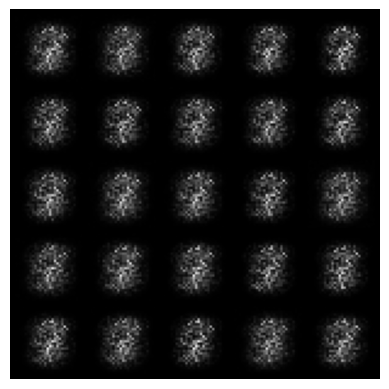

In [19]:
# show generated images
generated_images_ipm = trained_ipmgan.generator(test_noise)
plot_tensor_images(generated_images_ipm, num_images=25)

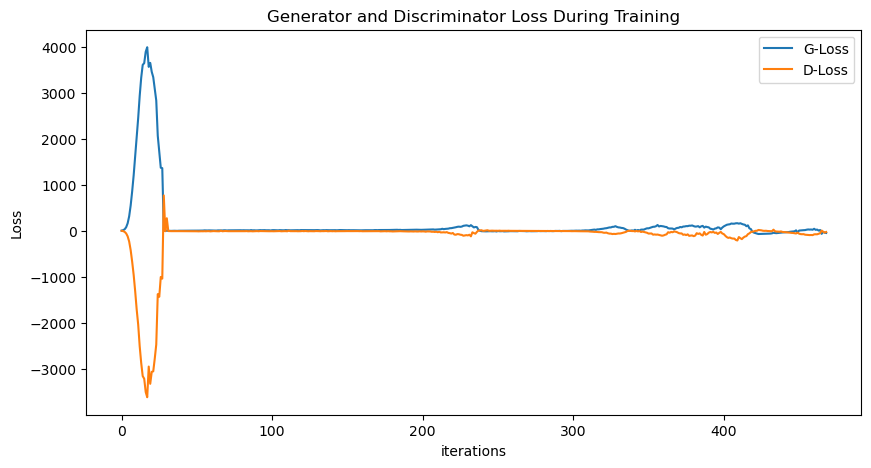

In [20]:
# plot losses
plot_losses(trained_ipmgan.generator_losses, trained_ipmgan.discriminator_losses)